# Phising Email Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [12]:
def check_for_nulls_dupes(df):
  print(f"Amount of Null Values: {df.isna().sum()}")
  print(f"Amount of Dupe Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop(words):
  word_tokens = " ".join(word_tokenize(words))
  filtered_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_tokens if not w.lower().strip() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grouped_insights(df, cols, x, metric_name):
  
  for col in cols:
    plt.figure(figsize=(10, 6))
    grouped_df = df.groupby(x)[col].sum().reset_index() if metric_name == "sum" else df.groupby(x)[col].mean().reset_index()
    sns.barplot(data=grouped_df, x=x, y =col, hue=col)
    plt.xlabel(x)
    plt.ylabel(metric_name)
    plt.title(f"{x} grouped by: {col} {metric_name}")
    plt.xticks(rotation=45)
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/phishing_email.csv")
df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

Amount of Null Values: text_combined    0
label            0
dtype: int64
Amount of Dupe Values: 408


In [5]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

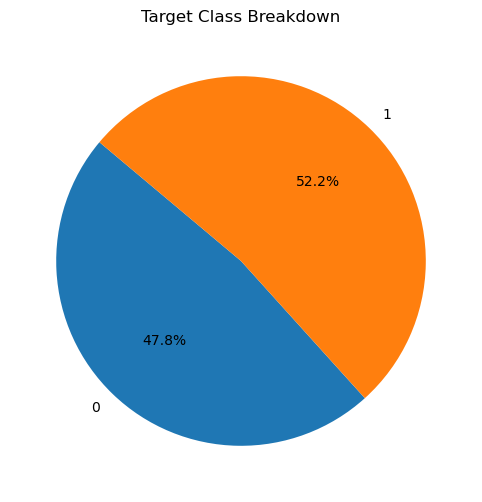

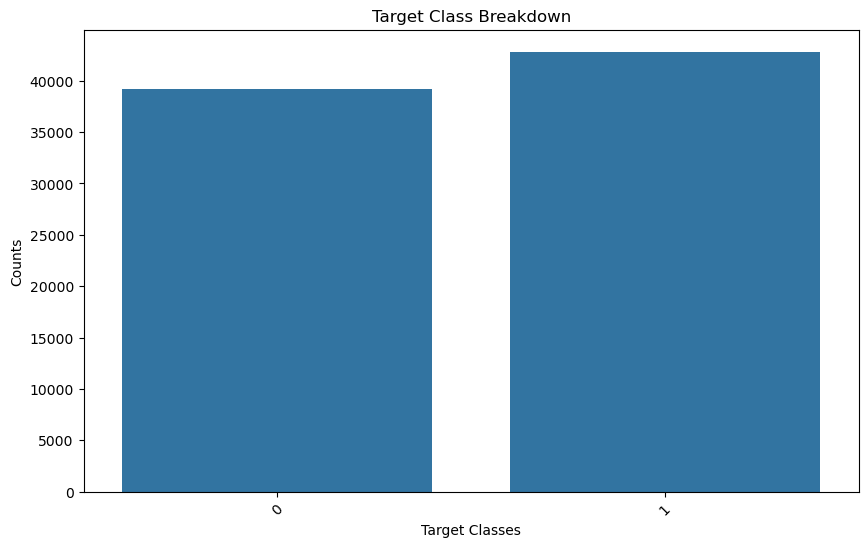

In [6]:
check_class_imbalance(df["label"])

# Balanced Class means our model can generalize more accurately on unseen data.

# Data Visuals

In [7]:
df["len_review"] = df["text_combined"].apply(lambda review: len(review))
df["word_count"] = df["text_combined"].apply(lambda review: len(review.split(" ")))

In [8]:
df.describe()

,label,len_review,word_count
count,82078.000000,8.207800e+04,82078.000000
mean,0.522003,1.290496e+03,160.728161
std,0.499519,1.553506e+04,544.989958
min,0.000000,1.000000e+00,2.000000
25%,0.000000,2.760000e+02,39.000000
50%,1.000000,5.580000e+02,78.000000
75%,1.000000,1.339000e+03,183.000000
max,1.000000,4.279526e+06,107710.000000


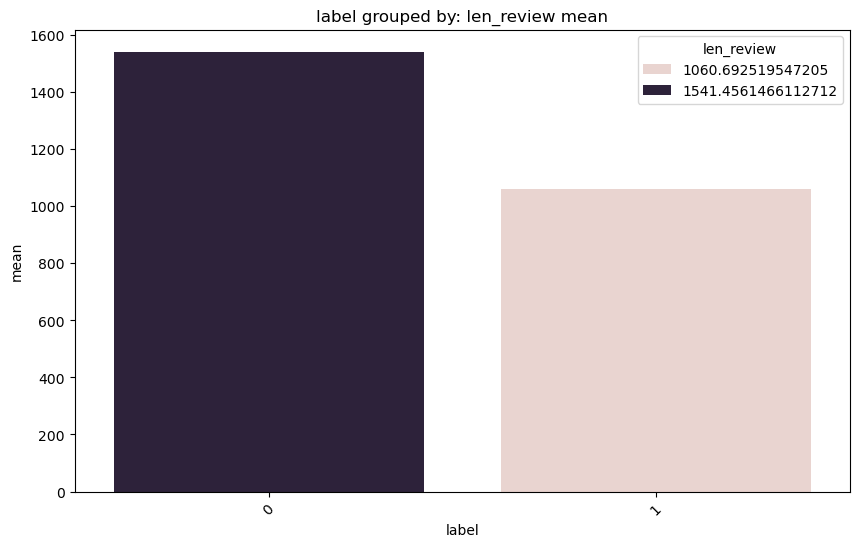

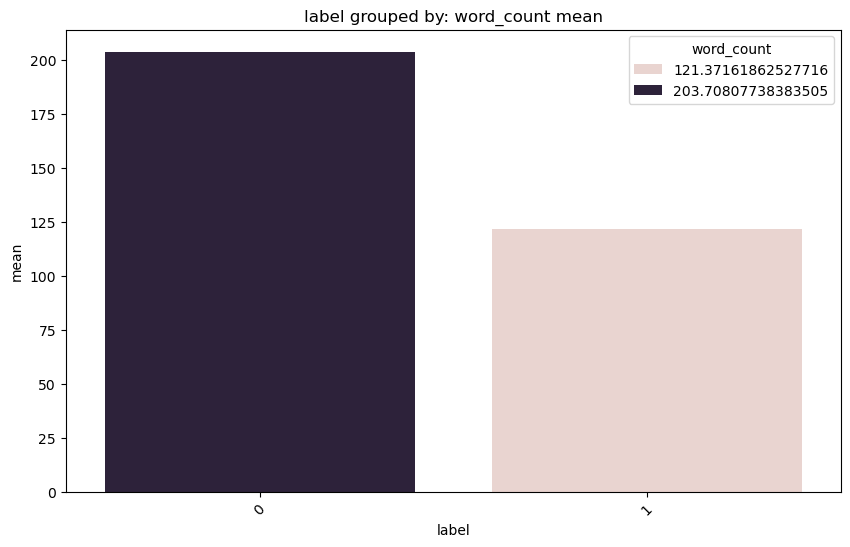

In [9]:
grouped_insights(df, ["len_review", "word_count"], "label", "mean")

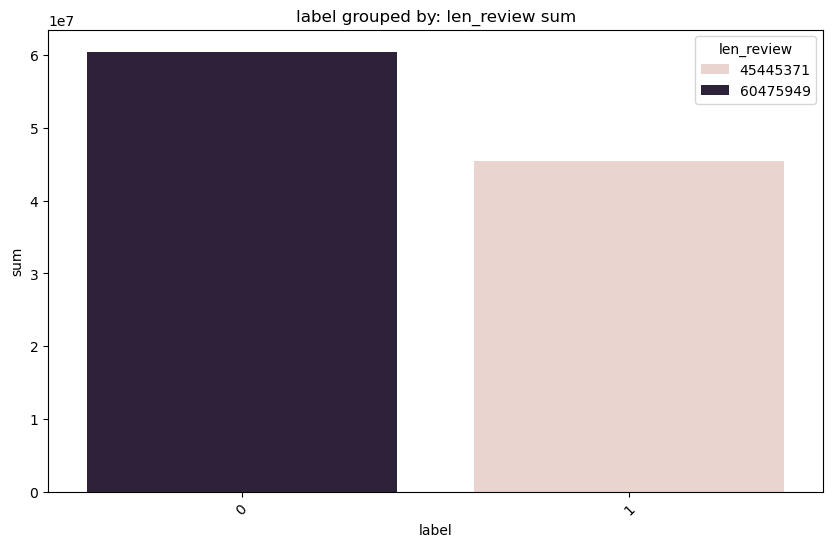

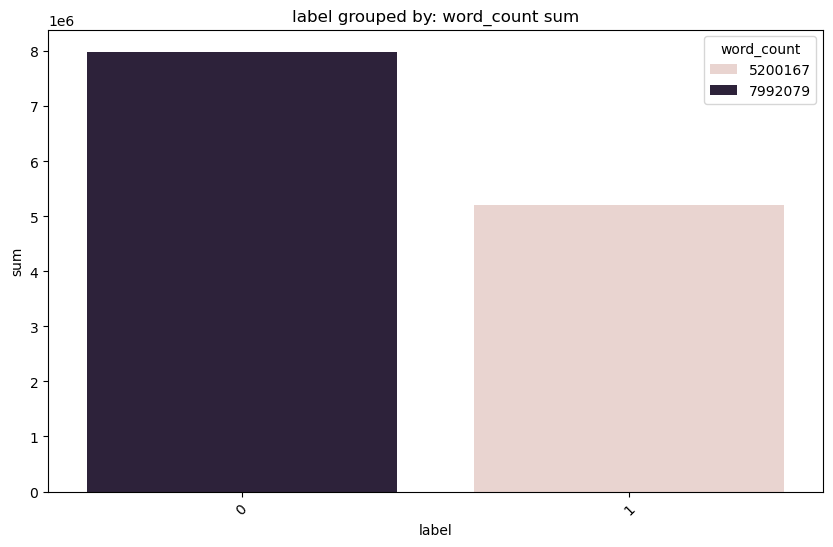

In [10]:
grouped_insights(df, ["len_review", "word_count"], "label", "sum")

# Data Preprocessing

In [13]:
df["text_combined"] = df["text_combined"].apply(remove_stop)

In [15]:
df = df[df["text_combined"] != ""]